In [131]:
from xml.dom import minidom
import cv2
from matplotlib import pyplot as plt
import os
import re
import json
import numpy as np

In [132]:
def prep_data(RootDir1):
    image_list = []
    xml_list = []
    for root, dirs, files in os.walk((os.path.normpath(RootDir1)), topdown=False):
    #print(root)
        for file in files:
            name = file.split('.')[-1]
            if 'jpg' in name:
                name = os.path.splitext(file)[0]
                #print(name)
                xml = name + ".xml"
                image_path = os.path.join(root,file)
                xml_path = os.path.join(root,xml)
                if os.path.exists(xml_path): 
                    image_list.append(image_path)
                    xml_list.append(xml_path)
    return image_list, xml_list

In [133]:
def draw_boxes(img, xml_path):
    mydoc = minidom.parse(xml_path)
    objects = mydoc.getElementsByTagName('object')
    window_name = 'Image'
    thickness = 3
    for obj in objects:
        name = obj.getElementsByTagName('name')
        #print(name[0].firstChild.data)
        box = obj.getElementsByTagName('bndbox')
        xmin = box[0].getElementsByTagName('xmin')
        ymin = box[0].getElementsByTagName('ymin')
        xmax = box[0].getElementsByTagName('xmax')
        ymax = box[0].getElementsByTagName('ymax')
        rotated = obj.getElementsByTagName('rotated')
        start_point = (int(xmin[0].firstChild.data), int(ymin[0].firstChild.data)) 
        end_point = (int(xmax[0].firstChild.data), int(ymax[0].firstChild.data))

        #start_point = (10, 10) 
        #end_point = (20, 20) 
        color = (255, 0, 0)   
        img = cv2.rectangle(img, start_point, end_point, color, thickness)
    return img

In [134]:
def visualize_boxes(image_path, xml_path):
    img = cv2.imread(image_path)
    img = draw_boxes(img, xml_path)

    plt.figure(figsize = (100,10))
    plt.imshow(img)
    plt.title('Lables and Inputs')
    plt.show()

# Prepare Image and XML path lists

In [135]:
RootDir1 = "/home/nchhabra/work/pcb_problem/DLAssignment/DLAssignment"
image_list, xml_list = prep_data(RootDir1)
#print(image_list)

# Visualize a data point

/home/nchhabra/work/pcb_problem/DLAssignment/DLAssignment/11.jpg
/home/nchhabra/work/pcb_problem/DLAssignment/DLAssignment/11.xml


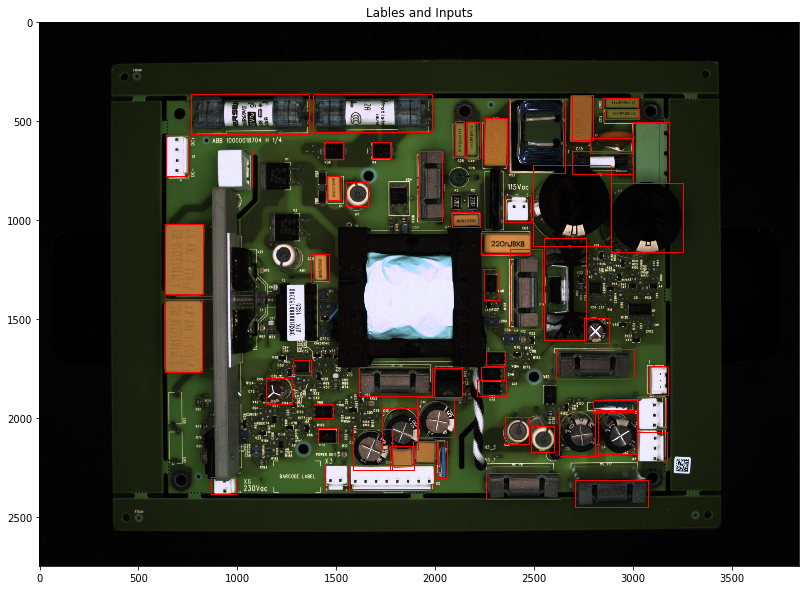

In [136]:
image = image_list[7]
xml = xml_list[7]
print(image)
print(xml)
visualize_boxes(image, xml)

# How many types of components exist

In [137]:
with open("/home/nchhabra/work/pcb_problem/DLAssignment/DLAssignment/number_to_type.json", "r") as read_file:
    data = json.load(read_file)
types = []
for key, value in data.items():
    types.append(str(value))
myset = set(types)
print("Number of unique components: ", len(myset))

Number of unique components:  33


# Visualize distribution of bounding boxes

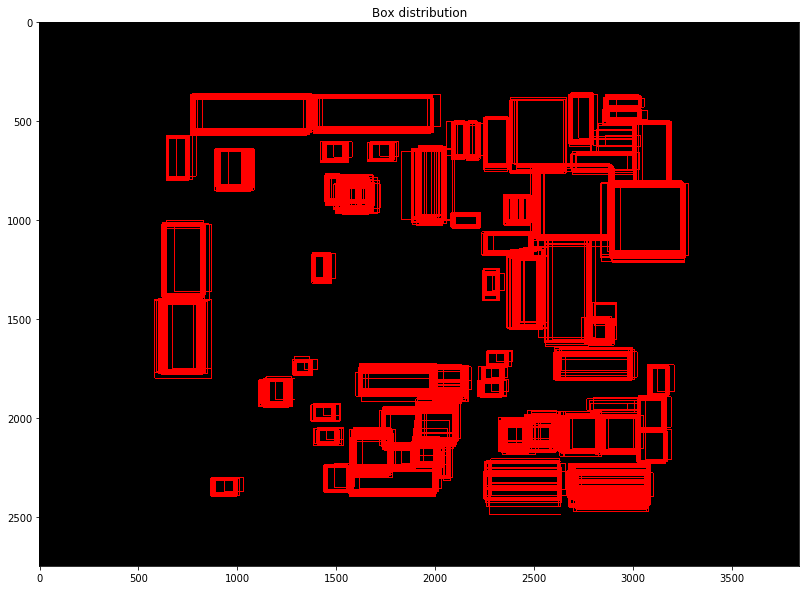

In [138]:
blank_image = np.zeros((2748,3840,3), np.uint8)
for xml in xml_list:
    blank_image = draw_boxes(blank_image,xml)
plt.figure(figsize = (100,10))
plt.imshow(blank_image)
plt.title('Box distribution')
plt.show()

CNN can handle above translation variation easily. 

# Method 1

Siamese network.

-We can formulate this problem similar to face recognition problem.

-We can create dataset of 33 components and negative class (which can be created using image of an empty board). Dataset will contain cropped images of components and negative class. Crop should be done with some tolerance so that it can cover variations of component placemments.


# Create Dataset

Go through all the images and crop the components and keep them in respective folders. We can resize the images now or later during the training. I have resized during training.

# Still TODO:
Balancing of dataset.

Data augmentation.

Also create data for negative class. Cases when component is not present. This could be easily achieved using empty board image. Infact this is the most important case to distinguish from. Currently I just mannualy created few exmaple by cropping images of board whereever the component was absent. I have used that during testing.

## Create dataset

In [139]:
data = "/home/nchhabra/work/pcb_problem/data"
counter = 0
for image_path,xml_path in zip(image_list,xml_list):
    img = cv2.imread(image_path)
    mydoc = minidom.parse(xml_path)
    objects = mydoc.getElementsByTagName('object')
    window_name = 'Image'
    thickness = 3
    counter = counter + 1
    counter_1 = 0
    for obj in objects:
        name = obj.getElementsByTagName('name')
        component_name = name[0].firstChild.data
        component_name = component_name.split("_")[-1]
        box = obj.getElementsByTagName('bndbox')
        xmin = box[0].getElementsByTagName('xmin')
        ymin = box[0].getElementsByTagName('ymin')
        xmax = box[0].getElementsByTagName('xmax')
        ymax = box[0].getElementsByTagName('ymax')
        rotated = obj.getElementsByTagName('rotated')
        xmin = int(xmin[0].firstChild.data)
        xmax = int(xmax[0].firstChild.data)
        ymin = int(ymin[0].firstChild.data)
        ymax = int(ymax[0].firstChild.data)
        start_point = (xmin, ymin) 
        end_point = (xmax, ymax)

        directory = os.path.join(data,component_name)
        counter_1 = counter_1 + 1
        if not os.path.exists(directory):
            os.makedirs(directory)
        crop_img = img[ymin:ymax, xmin:xmax] # we can use some tolerance or a standard crop which is bounding box of the variation we plotted above
        image_name = str(counter) + "_" + str(counter_1) + ".png"
        destination = os.path.join(directory,image_name)
        cv2.imwrite(destination,crop_img)

# Lets move to training part

In [140]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Some helpder functions to visualize cropped images

In [141]:
def imshow(img, text=None, should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [142]:
class Config():
    training_dir = "/home/nchhabra/work/pcb_problem/data"
    testing_dir = "/home/nchhabra/work/pcb_problem/test_data"
    train_batch_size = 50
    train_number_epochs = 100

In [143]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [144]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [155]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

# Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image. 1 indiciates dissimilar, and 0 indicates similar.

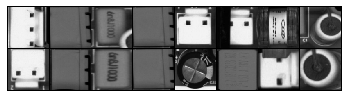

[[1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]]


In [156]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

# Define NN

In [147]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

# Define LOSS

In [148]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [149]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [150]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [151]:
counter = []
loss_history = [] 
iteration_number= 0

# Train

loss vs steps


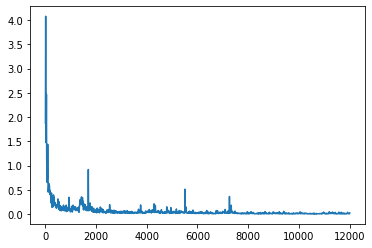

In [152]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            #print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
print("loss vs steps")            
show_plot(counter,loss_history)

# We can plot test loss to find the perfect model

Above model is obviously overfitted model.

# I Created a negative class just by taking some crops of location where component was absent

Let's now tes the model on some data.

# Test

I know this is not the perfect test. But still it gives some insight into how the model performs for now.


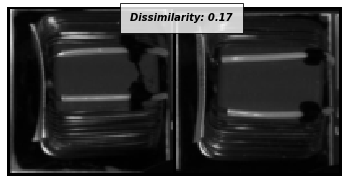

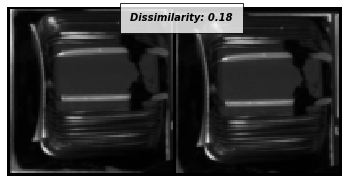

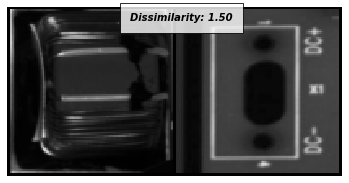

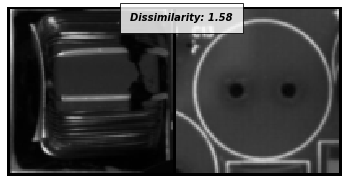

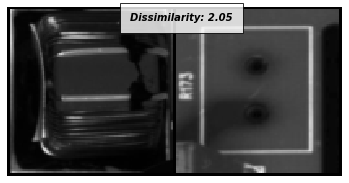

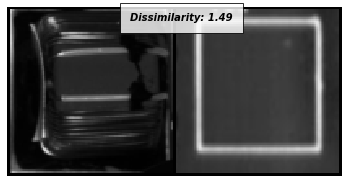

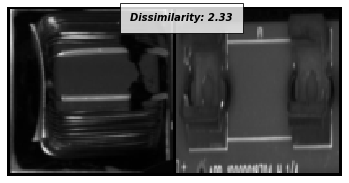

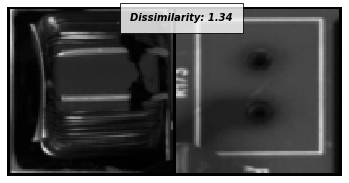

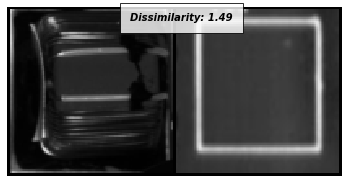

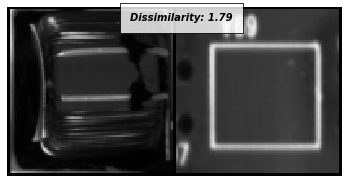

In [154]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()])
                                        ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

# Conclusions

1- Dissimilarity can be used to find missing component.

2- I haven't tested the rotation problem. But I believe that it is a similar problem, so it can also be solved using the same method.

3- This can be extened to other PCBs easily. As the domain stays the same. BONUS :) 

4- Basically we are creating embedding space. And distance can be used to find if the crop is similar to "crop having a component".

5- CNN is tranlstion invarient so little bit of movement of components here and there is taken care.

6- CNN is not rotation invarient so rotated component will be seen as dissimilar.

# Pipeline: 
--We know the approximate location of every components (60).

--We will save crops of perfect components. Mutiple instances.

--For every test image we will check for 60 ROI.

--We will compare each ROI to "true example" ("crop with component in place and with perfect rotation"). 

--We have to choose a threshold at which we say component doesn't exist or it is rotated.

--We can compare with N true examples take a democratic decision to come to conclusion.